# SCM.293 - Session 05 - CA-based Route Cost Approximation

Slightly adapted version of Winkenbach et al. (2016)

https://doi.org/10.1287/trsc.2015.0624

## Import Packages & Checks

In [1]:
import sys
import numpy as np
import math
import random

import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
print(sys.version)

3.6.15 | packaged by conda-forge | (default, Dec  3 2021, 18:49:43) 
[GCC Clang 11.1.0]


## Define Classes

### Demand segments

In [3]:
class segment:
    """
    A class used to represent a customer segment
    
    Parameters
    ----------
    x : float
        the x-coordinate of segment centroid
    y : float
        the y-coordinate of segment centroid
    A : float
        segment area
    g : float
        average demand density
    q : float
        average dropsize
    k : float
        distance metric proportionality factor
    c : float
        average local circuity
    segment_ID : str
        a (preferrably unique) identifier of the segment

    Other Attributes
    ----------
    loc : tuple
        the combined (x,y) location of the segment centroid
    type : str
        an identifier of the type of node the class represents (here: segment node)
    
    """
    
    def __init__(self,
                x,             
                y,
                A,
                g,
                q,
                k,
                c,
                segment_ID):

        
        self.x = x
        self.y = y
        self.loc = (self.x,self.y)
        self.A = A
        self.g = g
        self.q = float(q)
        self.k = float(k)
        self.c = float(c)
        self.segment_ID = str(segment_ID)
        self.type = 'segment'
        


### Depots

In [4]:
class depot:
    """
    A class used to represent a single depot node
    
    Parameters
    ----------
    x : float
        the x-coordinate of the depot location
    y : float
        the y-coordinate of the depot location
    cF : float
        fixed cost of the depot
    cp : float
        per parcel handling cost of the depot   
    dep_ID : str
        a (preferrably unique) identifier of the depot

    Other Attributes
    ----------
    loc : tuple
        the combined (x,y) location of the depot
    type : str
        an identifier of the type of node the class represents (here: depot node)
    
    """
    
    def __init__(self,
                x,
                y,
                F,
                cp,
                dep_ID):

        self.x = float(x)
        self.y = float(y)
        self.loc = (self.x,self.y)
        
        self.F = float(F)
        self.cp = float(cp)
    
        self.dep_ID = str(dep_ID)
        self.type = 'depot'
                


### Vehicles

In [5]:
class vehicle:
    """
    A class used to represent a vehicle type (note: NOT an individual vehicle!)
    
    Parameters
    ----------
    Q : float
        carrying capacity of the vehicle type (e.g., in parcels)
    F : float
        fixed cost per vehicle of this vehicle type
    cd : float
        variable cost per distance for this vehicle type
    cd : float
        variable cost per time for this vehicle type
    Tm : float
        maximum allowed service time (per vehicle)
    td : float
        service time per stop
    ts : float
        route setup time
    sl : float
        linehaul speed
    s : float
        inter-stop speed
    vehtype_ID : str
        a (preferrably unique) identifier of the vehicle type
    
    """
    
    def __init__(self,
                Q,               
                F,               
                cd,
                ch,
                Tm,
                td,
                ts,
                sl,
                s,
                vehtype_ID):     
    
        self.Q = float(Q)
        self.F = float(F)
        self.cd = float(cd)
        self.ch = float(ch)
        
        self.Tm = float(Tm)
        self.td = float(td)
        self.ts = float(ts)
        self.sl = float(sl)
        self.s = float(s)
        
        self.vehtype_ID = str(vehtype_ID)
        
        

## Define Functions

### Compute Distance Matrix

In [6]:
def calc_dist(orig,dest):
    """
    Calculates a Euclidian distance

    Parameters
    ----------
    orig : customer or depot object
        origin node
    dest : customer or depot object
        destination node
    mode : string
        type of distance metric to use

    Returns
    -------
    dist : float
        Euclidian distance between origin and destination node (in the unit of measurement the coordinates come in)
    """
        
    dist =  math.sqrt((orig[0]-dest[0])**2+(orig[1]-dest[1])**2) 
    
    return dist

In [7]:
def d_matrix(nodes):
    """
    Calculates a distance matrix

    Parameters
    ----------
    nodes : dict of segment or depot object
        all nodes (segments, depots) in the network

    Returns
    -------
    dist_mat : dict 
        origin-destination matrix of distances
    """
    
    dist_mat = dict(
            [((i,j),calc_dist(nodes[i].loc,nodes[j].loc)/1000) # since UTM coordinates come in meters, this converst to km
             for i in tqdm(nodes) for j in nodes]
            )
    path_mat = None
        
        
    return dist_mat, path_mat

### CA-based route cost approximation

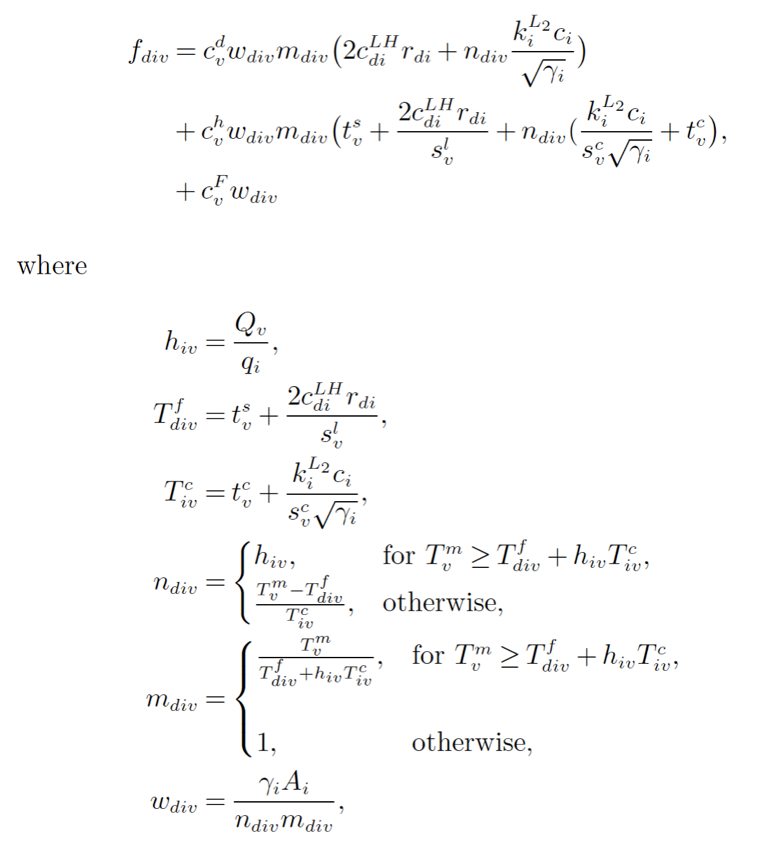


In [8]:
def ARCE(segment, vehicle, depot, param):
    
    """
    Calculates the augmented route cost estimation

    Parameters
    ----------
    segment : segment object
        segment in which vehicle routing is condisered 
    vehicle : vehicle object
        type of vehicle to be considered for routing
    depot : depot object
        depot from where distribution routes originate
    param: string
        name of parameter to be returned by the function ("h", "T_F", "T_c", "m", "n" or "f")
    
    Returns
    -------
    res : dict
        dictionnary containing total cost and all intermediate results
        
    """
    
    # Stops per route accounting for capacity only
    h = vehicle.Q / segment.q
    
    
    # Fixed duration of each route
    T_F = vehicle.ts + 2*linehaul_circuity[(depot.dep_ID, segment.segment_ID)]*distances[(depot.dep_ID, segment.segment_ID)]/vehicle.sl
    
    
    # Variable duration per customer of each route
    T_c = segment.c * segment.k / (math.sqrt(segment.g) * vehicle.s) + vehicle.td
    
    
    # Effective number of stops per route
    if h*T_c + T_F <= vehicle.Tm:
        n = h
    else:
        n = (vehicle.Tm - T_F ) /T_c
    
    # Number of routes per vehicle per day
    if h*T_c + T_F <= vehicle.Tm:
        m = vehicle.Tm / (h*T_c + T_F )
    else:
        m = 1
    
    # Fleet size
    w = (segment.g * segment.A) / (n * m)
    
    
    # Fixed cost of vehicles
    f_F = vehicle.F * w
    
    # Distance-based cost of routes
    f_D = (vehicle.cd * w * m * (2* distances[(depot.dep_ID, segment.segment_ID)] 
                                 + n * segment.k / math.sqrt(segment.g)))
           
         
    # Time-based cost of routes
    f_T = vehicle.ch * w * m * (vehicle.ts + 2*linehaul_circuity[(depot.dep_ID, segment.segment_ID)]*distances[(depot.dep_ID, segment.segment_ID)] / vehicle.sl
                            + n * (vehicle.td + segment.c * segment.k / (math.sqrt(segment.g) * vehicle.s)))

    
    # Total cost of routes
    f = f_F + f_D + f_T
    
    res = {}
    res["h"] = h
    res["T_F"] = T_F
    res["T_c"] = T_c
    res["n"] = n
    res["m"] = m
    res["w"] = w
    
    res["f_F"] = f_F
    res["f_D"] = f_D
    res["f_T"] = f_T
    res["f"] = f
    
    return res[param]


## Initialize Problem

### Load Data

#### Load Manhattan ZIP Codes

ZIP code shape files (obtained from NYC Open Data: https://data.cityofnewyork.us/widgets/i8iw-xf4u)

In [9]:
# Load an unpack shapefiles of NYC zip code boundaries
zipcode_gdf = gpd.read_file(f"zip://ZIP_CODE_040114.zip")

# Show data fields associated to these shape files
zipcode_gdf.dtypes

ZIPCODE         object
BLDGZIP         object
PO_NAME         object
POPULATION     float64
AREA           float64
STATE           object
COUNTY          object
ST_FIPS         object
CTY_FIPS        object
URL             object
SHAPE_AREA     float64
SHAPE_LEN      float64
geometry      geometry
dtype: object

In [10]:
# Filter it down to only Manhattan
zip_manhattan = zipcode_gdf[zipcode_gdf.PO_NAME=='New York']
zip_manhattan.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
21,10034,0,New York,39149.0,2.450389e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((1006203.169 257345.657, 1006214.666 ..."
22,10033,0,New York,54284.0,1.615605e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((1003020.865 256049.162, 1003096.046 ..."
24,10040,0,New York,41033.0,1.634074e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((1002564.135 253724.773, 1002596.698 ..."
32,10032,0,New York,57606.0,2.315957e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((998935.853 249154.260, 998945.457 24..."
36,10031,0,New York,57010.0,1.690215e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((1000830.039 241801.590, 1000913.103 ..."


#### Plot ZIP Code Data

In [11]:
# Project to Cartesian coordinate system with meters as unit
zip_manhattan = zip_manhattan.to_crs({'proj':'cea'})

/Users/mwinkenb/opt/anaconda3/envs/scm293/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("OrRd"))
  This is separate from the ipykernel package so we can avoid doing imports until


<AxesSubplot:>

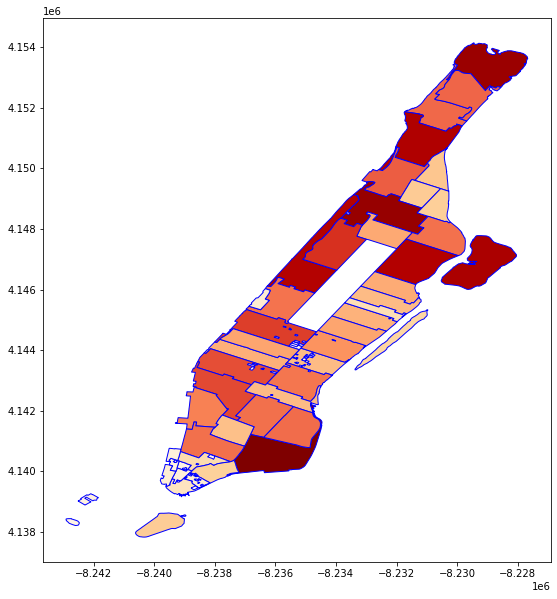

In [12]:
# Define custom color map
mycmapOrRd = plt.cm.OrRd
mycmapOrRd.set_under(color='gray')  

# Plot Manhattan ZIP codes and color by area size
zip_manhattan.plot(column='AREA', cmap=mycmapOrRd, vmin=0.0001, edgecolor='b', figsize=(10.0,10.0))

<AxesSubplot:>

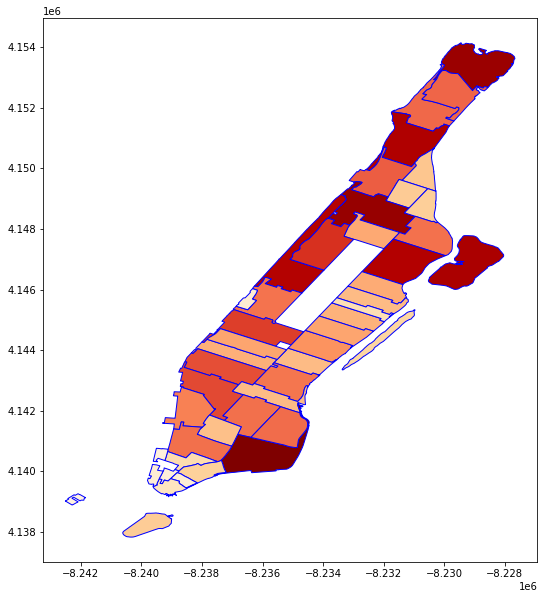

In [13]:
# Filter out very tiny (single-building) ZIP codes for clarity
zip_manhattan = zip_manhattan[zip_manhattan.AREA>1000000]

# Plot after clean-up
zip_manhattan.plot(column='AREA', cmap=mycmapOrRd, vmin=0.0001, edgecolor='b', figsize=(10.0,10.0))

#### Load Demand Data

In [14]:
# load demand data 
demand = pd.read_csv('SCM293_inclass_routeapproximation_5days_NYC.csv')

# filter it down to a single day
data = demand[demand.OrderDate=='2/26/14']

data.head()

,CustomerID,lat,lng,delivery_locality,delivery_zipcode,OrderSize,OrderDate
324,bdc27b12-7e74-4413-b38a-384ca95ed3e4,40.754767,-73.984915,manhattan,10036,3,2/26/14
520,e20a043a-1a2d-4cb4-872a-06e42f8aefea,40.724534,-73.999571,manhattan,10012,1,2/26/14
570,8540a944-25a9-4b89-acf5-cba29eac5e89,40.796494,-73.930039,manhattan,10035,8,2/26/14
571,5a3a3673-506e-4feb-96fa-0e139a4dd19e,40.749795,-73.971162,manhattan,10017,6,2/26/14
649,8eda5be4-e4fd-4091-8c85-4150dfd30091,40.723462,-74.006830,manhattan,10013,3,2/26/14


### Map Customer Stops to ZIP Codes

In [15]:
NStops = []
StopDensity = []
DropSize = []

# For each ZIP code in Manhattan
for index,row in tqdm(zip_manhattan.iterrows()):
    # Count the number of stops in that ZIP code
    NStops.append(len(data[data.delivery_zipcode==float(row.ZIPCODE)]))
    
    if len(data[data.delivery_zipcode==float(row.ZIPCODE)])>0:
        
        # Compute the stop density in that ZIP code
        StopDensity.append(len(data[data.delivery_zipcode==float(row.ZIPCODE)])/(zip_manhattan[zip_manhattan.ZIPCODE==row.ZIPCODE].geometry.area.sum()/(1000*1000)))
  
        # Compute the average drop size in that ZIP code
        DropSize.append((data[data.delivery_zipcode==float(row.ZIPCODE)].OrderSize.sum())/len(data[data.delivery_zipcode==float(row.ZIPCODE)]))

    else:
        StopDensity.append(0)
        DropSize.append(0)
        
# Write the number of stops, stop density, and drop size back to the data frame    
zip_manhattan['NStops'] = NStops
zip_manhattan['StopDensity'] = StopDensity
zip_manhattan['DropSize'] = DropSize

zip_manhattan.head()

47it [00:00, 104.66it/s]
/Users/mwinkenb/opt/anaconda3/envs/scm293/lib/python3.6/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,NStops,StopDensity,DropSize
21,10034,0,New York,39149.0,2.450389e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-8228805.867 4153757.318, -8228801.2...",0,0.000000,0.0
22,10033,0,New York,54284.0,1.615605e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-8230087.188 4153458.683, -8230056.9...",0,0.000000,0.0
24,10040,0,New York,41033.0,1.634074e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-8230271.724 4152922.214, -8230258.5...",1,0.658707,9.0
32,10032,0,New York,57606.0,2.315957e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-8231733.049 4151867.604, -8231729.1...",0,0.000000,0.0
36,10031,0,New York,57010.0,1.690215e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-8230972.898 4150169.410, -8230939.5...",0,0.000000,0.0


### Plot Customer Data on ZIP Codes

#### Number of stops

<AxesSubplot:>

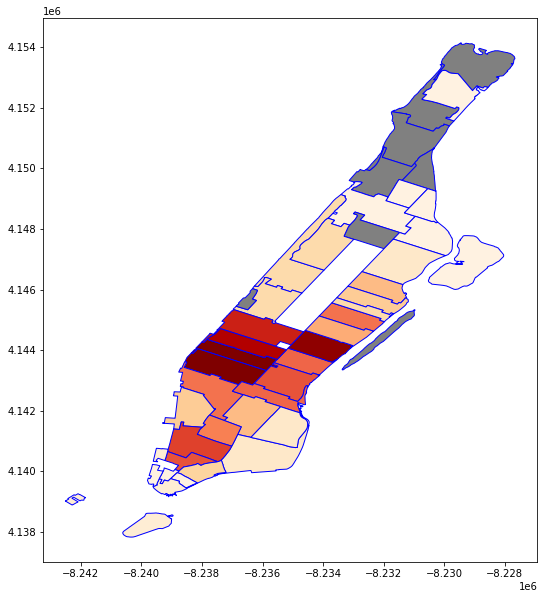

In [16]:
# Plot ZIP codes and color by number of stops
zip_manhattan.plot(column='NStops',cmap=mycmapOrRd, vmin=0.0001, edgecolor='b', figsize=(10.0,10.0))

#### Stop density

<AxesSubplot:>

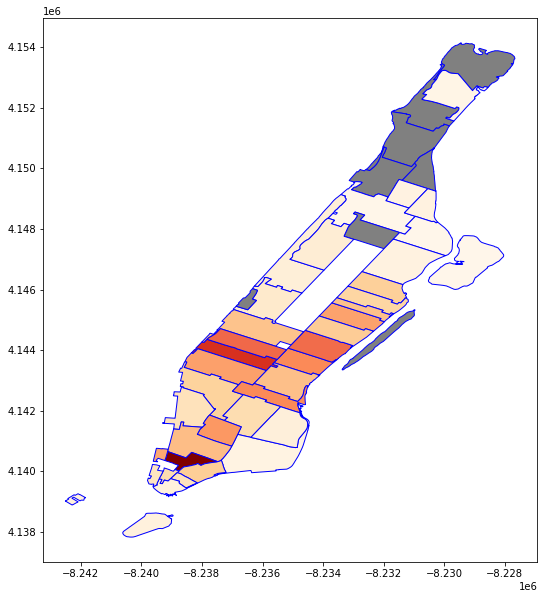

In [17]:
# Plot ZIP codes and color by stop density
zip_manhattan.plot(column='StopDensity', cmap=mycmapOrRd, vmin=0.0001, edgecolor='b', figsize=(10.0,10.0))

#### Drop size

<AxesSubplot:>

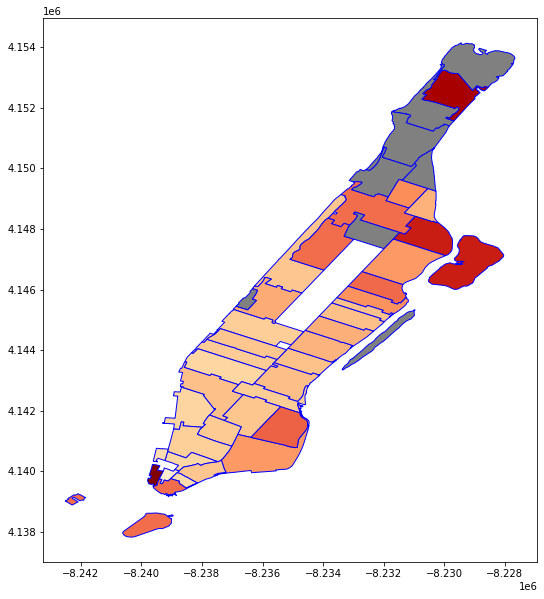

In [18]:
# Plot ZIP codes and color by drop size
zip_manhattan.plot(column='DropSize', cmap=mycmapOrRd, vmin=0.0001, edgecolor='b', figsize=(10.0,10.0))

### Create Objects

#### ZIP Codes as Demand Segments

In [19]:
segments = dict(
[(z, segment(
        x=zip_manhattan[zip_manhattan.ZIPCODE==z].geometry.centroid.x.mean(),
        y=zip_manhattan[zip_manhattan.ZIPCODE==z].geometry.centroid.y.mean(),
        A = zip_manhattan[zip_manhattan.ZIPCODE==z].geometry.area.sum()/1000000,
        k=0.57, # Daganzo (1994) L2 norm VRP
        c=random.uniform(2.2,3.5),
        g = zip_manhattan[zip_manhattan.ZIPCODE==z].StopDensity.mean(),
        q = zip_manhattan[zip_manhattan.ZIPCODE==z].DropSize.mean(),
        segment_ID=str(z)))
 for z in zip_manhattan.ZIPCODE.unique()
])

print(str(len(segments))+' demand segments created.')

44 demand segments created.


#### Depot

In [20]:
depot_x = (zip_manhattan[zip_manhattan.ZIPCODE=='10023'].geometry.centroid.x.mean() 
           + zip_manhattan[zip_manhattan.ZIPCODE=='10024'].geometry.centroid.x.mean())/2
depot_y = (zip_manhattan[zip_manhattan.ZIPCODE=='10023'].geometry.centroid.y.mean() 
           + zip_manhattan[zip_manhattan.ZIPCODE=='10024'].geometry.centroid.y.mean())/2

In [21]:
depots = dict(
[("D_1",depot(
        x=depot_x,
        y=depot_y,
        F=1000,
        cp=0.5,
        dep_ID="D_1"))
])


#### Vehicles

In [22]:
vehicles = dict(
[("van",vehicle(
        Q=50,
        F=100,
        cd=0.5,
        ch=50,
        Tm=8,
        td=0.1,
        ts=0.5,
        s=15,  # km/h
        sl=25, # km/h

        vehtype_ID="van")),
("bike",vehicle(
        Q=15,
        F=50,
        cd=0.1,
        ch=20,
        Tm=8,
        td=0.1,
        ts=0.3,
        s=8.5,  # km/h
        sl=10, # km/h

        vehtype_ID="bike"))]
)

### Calculate Distance Matrix

Define set of all nodes

In [23]:
nodes = {**depots, **segments}

Calculate distances

In [24]:
distances, path = d_matrix(nodes)

100%|██████████| 45/45 [00:00<00:00, 13553.33it/s]


Linehaul circuities: neglected for simplicity (i.e., set to 1.0)

In [25]:
linehaul_circuity = dict([
    ((d,i),2.1) for d in depots for i in segments
])

##  Generate solutions

### Set Which Combination of Segment and Vehicle to Explore

In [26]:
mysegment = '10036' #10018, 10036, 10010
myvehicle = 'van'

Stops in that segment

In [27]:
round(segments[mysegment].g*segments[mysegment].A,1)

21.0

### Compute KPIs with ARCE Formula

__Nominal stops per route__ (i.e., accounting for capacity only)

In [28]:
ARCE(segments[mysegment], vehicles[myvehicle], depots["D_1"], "h")

15.441176470588236

Fixed __line-haul duration__ of each route

In [29]:
ARCE(segments[mysegment], vehicles[myvehicle], depots["D_1"], "T_F")

0.9114191862875618

Variable __en-route duration per stop__ of each route

In [30]:
ARCE(segments[mysegment], vehicles[myvehicle], depots["D_1"], "T_c")

0.1272060678764525

__Effective stops per route__ (i.e., accounting for time constraints)

In [31]:
ARCE(segments[mysegment], vehicles[myvehicle], depots["D_1"], "n")

15.441176470588236

Number of __routes per vehicle per day__

In [32]:
ARCE(segments[mysegment], vehicles[myvehicle], depots["D_1"], "m")

2.7819985636958653

__Number of vehicles__ needed (i.e., number of vehicles that would be needed to serve just this segment)

In [33]:
ARCE(segments[mysegment], vehicles[myvehicle], depots["D_1"], "w")

0.4888571898445734

Route __fixed cost__

In [34]:
ARCE(segments[mysegment], vehicles[myvehicle], depots["D_1"], "f_F")

48.88571898445734

__Distance-based cost__ of routes

In [35]:
ARCE(segments[mysegment], vehicles[myvehicle], depots["D_1"], "f_D")

4.6743258781086805

__Time-based cost__ of routes

In [36]:
ARCE(segments[mysegment], vehicles[myvehicle], depots["D_1"], "f_T")

195.5428759378294

__Expected routing cost__ to serve demand in that segment (i.e., full-blown route cost estimation)

In [37]:
ARCE(segments[mysegment], vehicles[myvehicle], depots["D_1"], "f")

249.10292080039542

__Cost per stop__

In [38]:
ARCE(segments[mysegment], vehicles[myvehicle], depots["D_1"], "f")/(segments[mysegment].g*segments[mysegment].A)

11.862043847637878

## Compare Vehicles Across ZIP Codes

### Compute cost for serving each ZIP code by van or by bike and compare

In [39]:
CostVan = []
CostBike = []
VehChoice = []
wVans = []
wBikes = []
CostDiff = []

# For each ZIP code in Manhattan
for index,row in tqdm(zip_manhattan.iterrows()):
    
    if segments[row.ZIPCODE].q > 0:
        CostVan.append(ARCE(segments[row.ZIPCODE], vehicles['van'], depots["D_1"], "f")/(segments[row.ZIPCODE].g*segments[row.ZIPCODE].A))
        
        CostBike.append(ARCE(segments[row.ZIPCODE], vehicles['bike'], depots["D_1"], "f")/(segments[row.ZIPCODE].g*segments[row.ZIPCODE].A))
        
        if ARCE(segments[row.ZIPCODE], vehicles['van'], depots["D_1"], "f") < ARCE(segments[row.ZIPCODE], vehicles['bike'], depots["D_1"], "f"):
            VehChoice.append('van')
            wVans.append(ARCE(segments[row.ZIPCODE], vehicles['van'], depots["D_1"], "w"))
            wBikes.append(0)
        else:
            VehChoice.append('bike')
            wVans.append(0)
            wBikes.append(ARCE(segments[row.ZIPCODE], vehicles['bike'], depots["D_1"], "w"))
            
        CostDiff.append(ARCE(segments[row.ZIPCODE], vehicles['bike'], depots["D_1"], "f")-ARCE(segments[row.ZIPCODE], vehicles['van'], depots["D_1"], "f"))
                
    else:
        CostVan.append(0)
        CostBike.append(0)
        VehChoice.append('None')
        wVans.append(0)
        wBikes.append(0)
        CostDiff.append(0)
        
# Write the number of stops, stop density, and drop size back to the data frame    
zip_manhattan['CostVan'] = CostVan
zip_manhattan['CostBike'] = CostBike
zip_manhattan['CostDiff'] = CostDiff
zip_manhattan['VehChoice'] = VehChoice
zip_manhattan['wBikes'] = wBikes
zip_manhattan['wVans'] = wVans

zip_manhattan.head()

47it [00:00, 3450.59it/s]


,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,...,geometry,NStops,StopDensity,DropSize,CostVan,CostBike,CostDiff,VehChoice,wBikes,wVans
21,10034,0,New York,39149.0,2.450389e+07,NY,New York,36,061,http://www.usps.com/,...,"POLYGON ((-8228805.867 4153757.318, -8228801.2...",0,0.000000,0.0,0.000000,0.000000,0.000000,None,0.0,0.000000
22,10033,0,New York,54284.0,1.615605e+07,NY,New York,36,061,http://www.usps.com/,...,"POLYGON ((-8230087.188 4153458.683, -8230056.9...",0,0.000000,0.0,0.000000,0.000000,0.000000,None,0.0,0.000000
24,10040,0,New York,41033.0,1.634074e+07,NY,New York,36,061,http://www.usps.com/,...,"POLYGON ((-8230271.724 4152922.214, -8230258.5...",1,0.658707,9.0,37.867017,69.602161,31.735145,van,0.0,0.072043
32,10032,0,New York,57606.0,2.315957e+07,NY,New York,36,061,http://www.usps.com/,...,"POLYGON ((-8231733.049 4151867.604, -8231729.1...",0,0.000000,0.0,0.000000,0.000000,0.000000,None,0.0,0.000000
36,10031,0,New York,57010.0,1.690215e+07,NY,New York,36,061,http://www.usps.com/,...,"POLYGON ((-8230972.898 4150169.410, -8230939.5...",0,0.000000,0.0,0.000000,0.000000,0.000000,None,0.0,0.000000


### Print and Plot the Results

In [40]:
# Check which vehicle type is better how often
print('Vans were cheaper in '+str(len(zip_manhattan[zip_manhattan.VehChoice=='van']))+' ZIP codes')
print('Bikes were cheaper in '+str(len(zip_manhattan[zip_manhattan.VehChoice=='bike']))+' ZIP codes')

# Count total fleet size
print('We need a total of ')
print('... '+str(round(zip_manhattan.wVans.sum(),1))+' vans')
print('... '+str(round(zip_manhattan.wBikes.sum(),1))+' bikes')

Vans were cheaper in 33 ZIP codes
Bikes were cheaper in 6 ZIP codes
We need a total of 
... 7.0 vans
... 3.9 bikes


In [41]:
mymaxcost = max(max(zip_manhattan.CostBike), max(zip_manhattan.CostVan))
print('The highest cost per stop was '+str(mymaxcost))

The highest cost per stop was 69.60216139991908


Show map of __van cost per stop__

<AxesSubplot:>

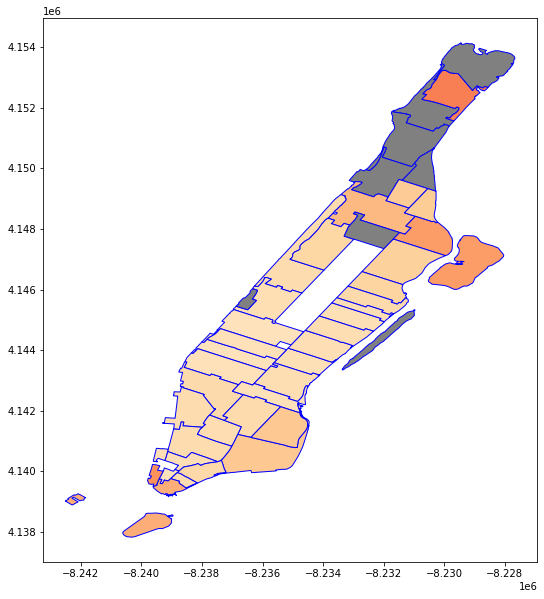

In [42]:
zip_manhattan.plot(column='CostVan', cmap=mycmapOrRd, vmin=0.0001, vmax=mymaxcost, edgecolor='b', figsize=(10.0,10.0))

Show map of __bike cost per stop__

<AxesSubplot:>

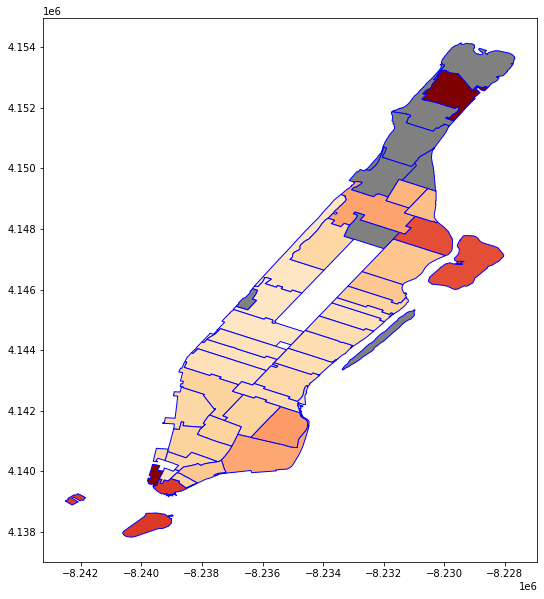

In [43]:
zip_manhattan.plot(column='CostBike', cmap=mycmapOrRd, vmin=0.0001, vmax=mymaxcost, edgecolor='b', figsize=(10.0,10.0))

Show map of __cost differentials__ between bikes and vans

/Users/mwinkenb/opt/anaconda3/envs/scm293/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  after removing the cwd from sys.path.


<AxesSubplot:>

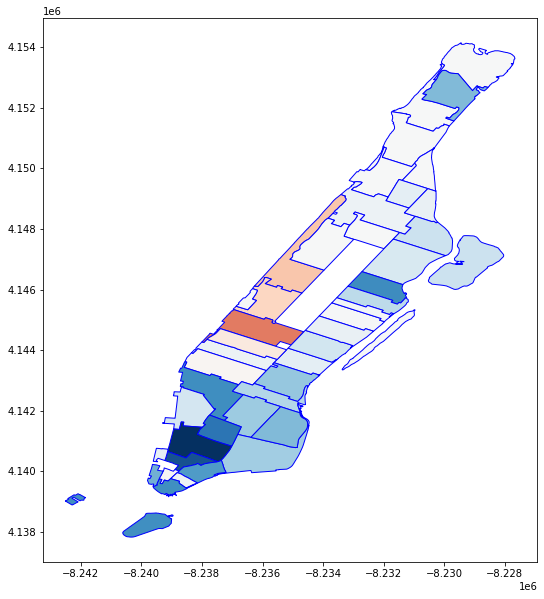

In [44]:
from matplotlib import colors
diffrange=zip_manhattan.CostDiff.abs().max()

divnorm = colors.DivergingNorm(vmin=-diffrange, vcenter=0, vmax=diffrange)
zip_manhattan.plot(column='CostDiff', cmap='RdBu', norm=divnorm, edgecolor='b', figsize=(10.0,10.0))

Show map of __vehicle choice__

<AxesSubplot:>

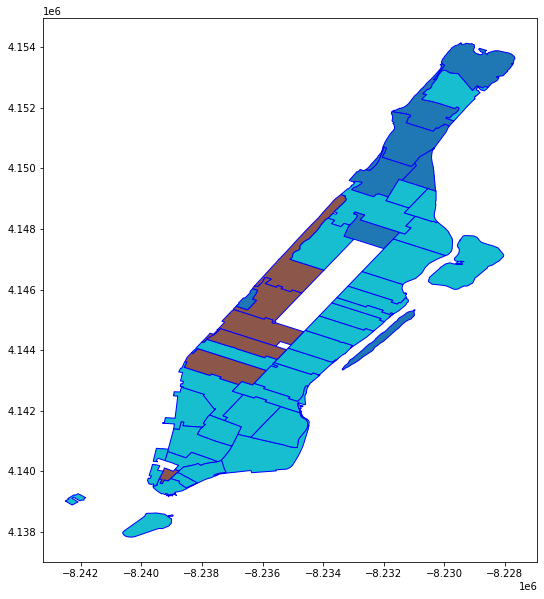

In [45]:
zip_manhattan.plot(column='VehChoice', cmap='tab10', edgecolor='b', figsize=(10.0,10.0))